# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr/)

# RAMP on detector anomaly detection

<i>James Catmore (UOslo), Imad Chaabane (LRI/UPSud), Sergei Gleyzer (UFlorida), Cécile Germain (LRI/UPSud), Isabelle Guyon (LRI/UPSud), Victor Estrade (LRI/UPSud), Balazs Kegl (LAL/CNRS), Edouard Leicht (LAL/CNRS), Gilles Louppe (NYU), David Rousseau (LAL/CNRS), Jean-Roch Vlimant (CalTech)</i>

<h2>Introduction</h2>

Anomaly detection, where we seek to identify events or datasets that deviate from those normally encountered, is a common task in experimental particle physics. For example, two runs recorded on the same day with identical accelerator and detector conditions and the same trigger menu should not be distinguishable statistically. If they are, some unexpected systematic effect must be present which acts to skew each event or a subset of the events, leading to a collective anomaly. There are many ways in which such problems can arise: for instance, the data acquisition or reconstruction software might be misconfigured, or some subcomponent of the detector might be malfunctioning.    
 
Conversely, an otherwise normal dataset may contain individual events which are somehow unusual. These point anomalies may arise due to a problem with the detector, data acquisition, trigger, or reconstruction that only occur in very rare circumstances. 

For both cases it would be highly desirable to devise a mechanism that could automatically scan all new datasets, detect any anomalous features, and alert a human being to enable detailed investigation. This is the subject of this RAMP. 

<h3>The prediction task</h3>

The nature of the challenge is to devise a classifier that can distinguish the anomalous cases from the bulk of the data in a test dataset, having first trained the classifier on a training dataset. Whilst the anomalous events are labelled in the training set, no distinction is made between the different types of distortions.

<b>The challenge in this RAMP is to weparate a skewed data point from a normal data point.</b>

<h2>Data</h2>

A version of the <a href="http://opendata.cern.ch/collection/ATLAS-Higgs-Challenge-2014?ln=en">HiggsML dataset</a> (used in the <a href="https://higgsml.lal.in2p3.fr/">Kaggle Challenge</a> in 2014) is provided. It contains a mixture of Higgs particles decaying into tau pairs and the principal background processes. One half of the data is unchanged but the other half has been artificially distorted in various ways.

The full dataset contains approximately 800K events.
We are giving you 100k events to build models and will use the rest to test them.

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0  
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)  

In [1]:
from __future__ import division, print_function
import os
import sys
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try :
    import seaborn as sns; sns.set()
except ImportError:
    print("seaborn not found on your computer. "
          "Install it if you want pretty charts \n"
          "If you have internet access you can run in a cell : \n"
          "!pip install -U seaborn ")

pd.set_option('display.max_columns', None)

In [2]:
%matplotlib inline

## Exploratory data analysis

### Loading the data

In [3]:
data = pd.read_csv('data/train.csv.gz', compression='gzip')
X_df = data.drop(['isSkewed'], axis=1)
Y_df = data[['isSkewed']]

In [4]:
data.head()

,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,isSkewed
0,14.218,71.234,26.794,2.349,4.067,185.627,0.630,-0.705,48.398,-1.281,-1.168,30.537,-1.481,1.173,16.776,1.812,0
1,49.762,114.246,3.963,3.101,3.963,99.045,1.104,-1.413,47.070,0.380,1.216,51.976,1.502,-1.675,17.028,2.627,0
2,14.032,99.843,35.942,2.647,3.820,143.977,0.644,-0.306,63.414,-0.654,2.595,40.897,-0.971,-0.033,48.930,-0.348,1
3,15.926,80.572,197.311,1.253,2.735,333.534,2.617,0.495,37.260,0.463,-0.862,97.518,-0.786,-0.751,63.339,-0.954,0
4,11.974,75.853,91.171,1.877,5.374,260.195,0.440,1.277,70.589,0.214,2.586,31.069,0.412,0.719,35.410,1.082,1


## Feature description

See more details at http://opendata.cern.ch/record/329 page 16.


- **DER_mass_transverse_met_lep:** The transverse mass between the missing transverse energy and the lepton.

- **DER_mass_vis:** The invariant mass of the hadronic tau and the lepton.

- **DER_pt_h:** The modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton, and the missing transverse energy vector.


- **DER_deltar_tau_lep:** The R separation between the hadronic tau and the lepton.

- **DER_pt_tot:** The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num $\geq$) and the subleading jet (if PRI jet num = 2) (but not of any additional jets).

- **DER_sum_pt:** The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI jet num $\geq$ 1) and the subleading jet (if PRI jet num = 2) and the other jets (if PRI jet num = 3).

- **DER_pt_ratio_lep_tau:** The ratio of the transverse momenta of the lepton and the hadronic tau.

- **DER_met_phi_centrality:** The centrality of the azimuthal angle of the missing transverse energy vector w.r.t. the hadronic tau and the lepton.

- **PRI_tau_pt:** The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the hadronic tau.

- **PRI_tau_eta:** The pseudorapidity $\eta$ of the hadronic tau.

- **PRI_tau_phi:** The azimuth angle $\phi$ of the hadronic tau.

- **PRI_lep_pt:** The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the lepton (electron or muon).

- **PRI_lep_eta:** The pseudorapidity $\eta$ of the lepton.

- **PRI_lep_phi:** The azimuth angle $\phi$ of the lepton.

- **PRI_met:** The missing transverse energy $\overrightarrow{E}^{miss}_{T}$

- **PRI_met_phi:** The azimuth angle $\phi$ of the mssing transverse energy

- **isSkewed:** The event origin, 0: original distribution ; 1: skewed distribution .



Check for missing values

In [5]:
(X_df == -999.).any()

DER_mass_transverse_met_lep    False
DER_mass_vis                   False
DER_pt_h                       False
DER_deltar_tau_lep             False
DER_pt_tot                     False
DER_sum_pt                     False
DER_pt_ratio_lep_tau           False
DER_met_phi_centrality         False
PRI_tau_pt                     False
PRI_tau_eta                    False
PRI_tau_phi                    False
PRI_lep_pt                     False
PRI_lep_eta                    False
PRI_lep_phi                    False
PRI_met                        False
PRI_met_phi                    False
dtype: bool

In [6]:
Y_df.head()

,isSkewed
0,0
1,0
2,1
3,0
4,1


In [7]:
X_df.head()

,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi
0,14.218,71.234,26.794,2.349,4.067,185.627,0.630,-0.705,48.398,-1.281,-1.168,30.537,-1.481,1.173,16.776,1.812
1,49.762,114.246,3.963,3.101,3.963,99.045,1.104,-1.413,47.070,0.380,1.216,51.976,1.502,-1.675,17.028,2.627
2,14.032,99.843,35.942,2.647,3.820,143.977,0.644,-0.306,63.414,-0.654,2.595,40.897,-0.971,-0.033,48.930,-0.348
3,15.926,80.572,197.311,1.253,2.735,333.534,2.617,0.495,37.260,0.463,-0.862,97.518,-0.786,-0.751,63.339,-0.954
4,11.974,75.853,91.171,1.877,5.374,260.195,0.440,1.277,70.589,0.214,2.586,31.069,0.412,0.719,35.410,1.082


In [8]:
X_df.describe()

,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,52.609261,89.775437,69.141507,2.402279,30.286746,169.946936,1.708679,-0.129230,39.725153,0.051813,-0.004350,57.200424,-0.024398,0.043653,42.723344,-0.012203
std,43.148200,61.864989,95.855470,0.814906,73.666250,138.752247,2.418627,1.194385,23.362212,1.276227,1.816103,77.412637,1.266968,1.819345,33.013756,1.813812
min,0.000000,7.829000,0.005000,0.257000,0.005000,46.286000,0.045000,-1.414000,20.000000,-2.494000,-3.141000,26.000000,-2.494000,-3.142000,0.247000,-3.141000
25%,20.026750,60.672000,16.648500,1.824000,3.413000,78.978000,0.872000,-1.371000,25.193000,-0.907000,-1.578000,32.533000,-1.018000,-1.521000,21.722750,-1.577000
50%,47.820000,75.771000,41.558000,2.507000,15.828000,124.627000,1.268000,-0.361000,32.532000,0.022000,-0.020000,40.944000,-0.054000,0.084000,35.370000,-0.016000
75%,75.548500,96.788500,86.204250,2.978000,29.946250,211.277000,1.789000,1.229000,46.029000,0.975000,1.574000,54.715250,0.955000,1.621000,53.568750,1.565000
max,1318.682000,2145.712000,3157.497000,6.025000,2656.503000,3563.050000,99.890000,1.414000,654.005000,2.800000,3.142000,2985.960000,2.497000,3.141000,585.920000,3.142000


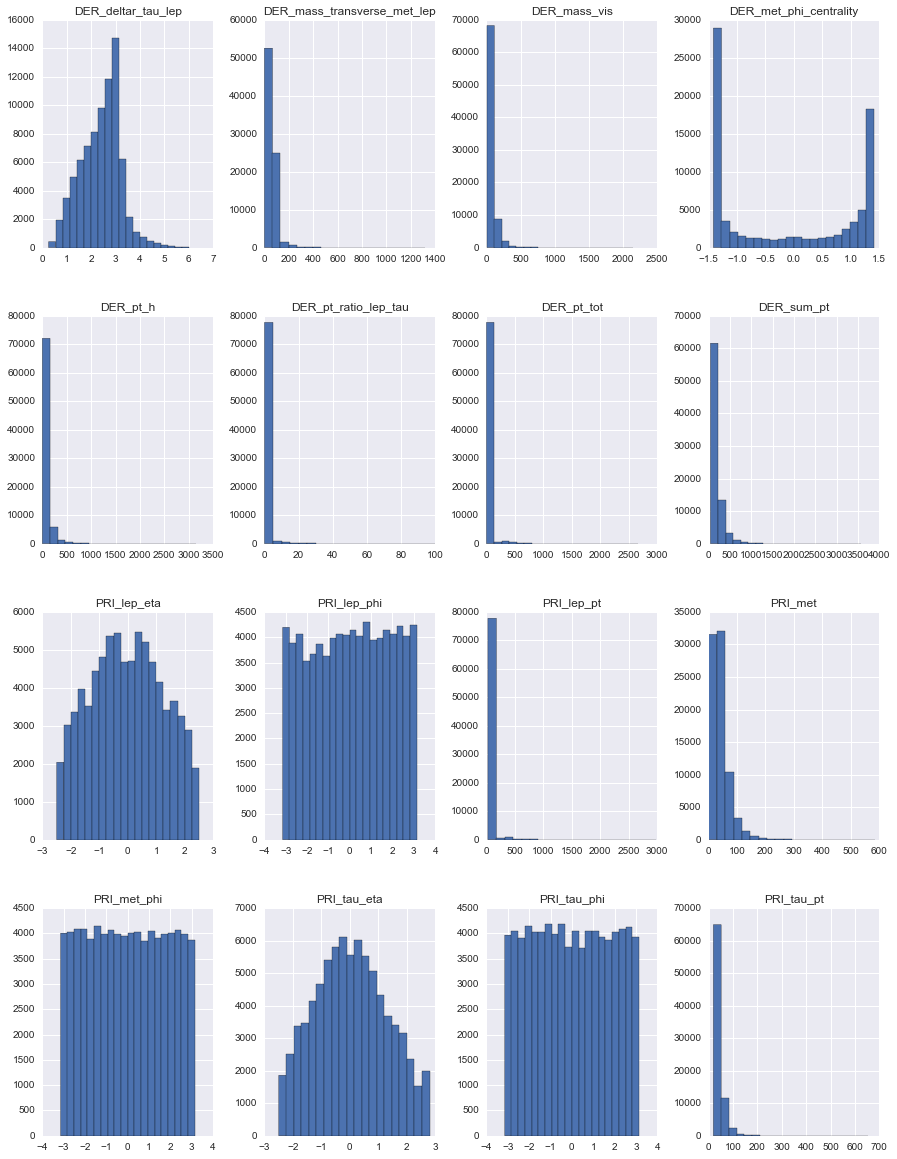

In [9]:
X_df.hist(figsize=(15, 20), bins=20);

Look at the distribution difference between the *original* and *skewed* data on each feature.

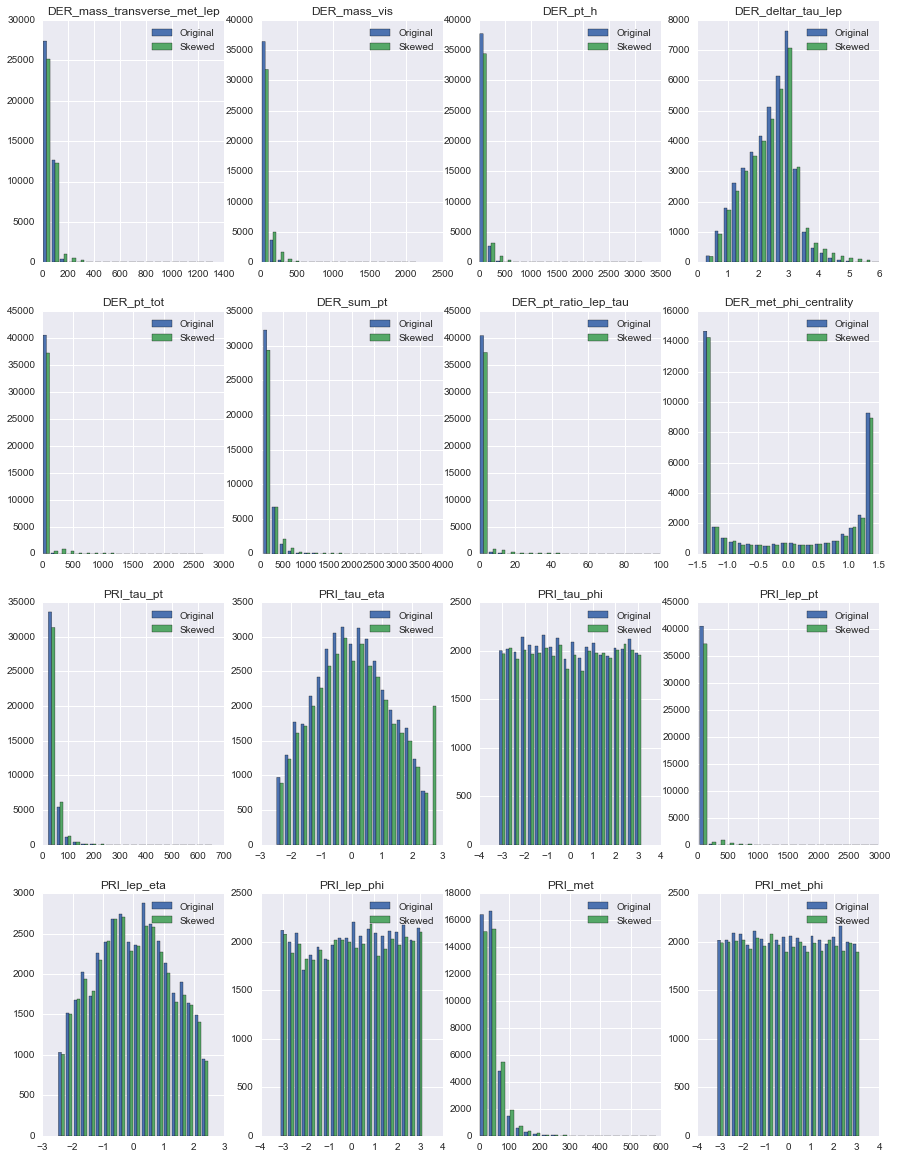

In [10]:
# Choose a feauture to look at :
X_origin = X_df.values[np.where(Y_df==0)[0]]
X_skewed = X_df.values[np.where(Y_df==1)[0]]

n_features = X_df.shape[1]
fig, axes = plt.subplots(int(np.ceil(n_features//4)), 4, figsize=(15,20))
axes = axes.ravel()
for i in range(n_features):
    axes[i].hist([X_origin[:, i], X_skewed[:, i]], bins=20, label=['Original', 'Skewed']);
    axes[i].set_title(X_df.columns[i])
    axes[i].legend(loc=1)


## Prediction model 
We are going to follow the scikit-learn API specs. 
Basically, 
- inherit from `BaseEstimator`,
- initiate all of the arguments and configurations in the `__init__()` function,
- implement a `fit()`, `predict()`, and `predict_proba()` function.

More information in the [official documentation](http://scikit-learn.org/stable/developers/contributing.html#apis-of-scikit-learn-objects).

The initial classifier in your sandbox. The following cell is *not* executed in the notebook, rather it saves its content in the file in the first line, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [1]:
%%file submissions/starting_kit/classifier.py
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.clf = RandomForestClassifier(
            n_estimators=2, max_leaf_nodes=2, random_state=61)
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)



Overwriting submissions/starting_kit/classifier.py


## Variable importances

This will plot the variable importance according to your model.

**Your model may not implement it, this is an example of how to do it with RandomForest**

First, load your classifier into the notebook.

In [ ]:
# %load submissions/starting_kit/classifier.py
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.clf = RandomForestClassifier(
            n_estimators=2, max_leaf_nodes=2, random_state=61)
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


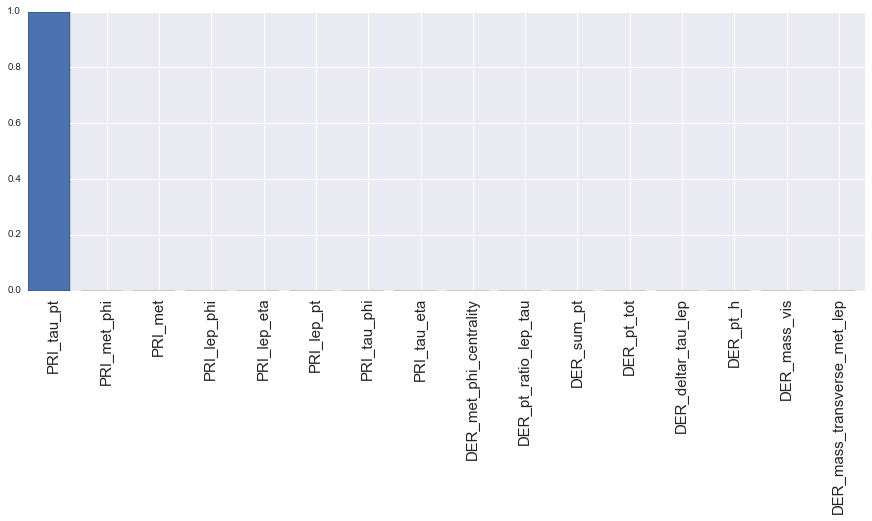

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

plt.figure(figsize=(15, 5))

X = X_df.values
y = Y_df.values.ravel()
skf = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=43)

valid_train_is, valid_test_is = list(skf.split(X, y))[0]

X_valid_train = X[valid_train_is]
y_valid_train = y[valid_train_is]
X_valid_test = X[valid_test_is]
y_valid_test = y[valid_test_is]

clf = Classifier()
clf.fit(X_valid_train, y_valid_train)

ordering = np.argsort(clf.clf.feature_importances_)[::-1][:50]

importances = clf.clf.feature_importances_[ordering]
feature_names = X_df.columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

## Roc curve

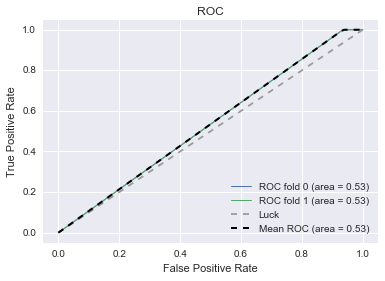

In [14]:
from scipy import interp
from sklearn.metrics import roc_curve , auc
from sklearn.pipeline import make_pipeline

# Run classifier with cross-validation and plot ROC curves
classifier = Classifier()

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

n_splits = 2

skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=43)
for i, (valid_train_is, valid_test_is) in enumerate(skf.split(X, y)):
    classifier.fit(X[valid_train_is], y[valid_train_is])
    probas_ = classifier.predict_proba(X[valid_test_is])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[valid_test_is], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= n_splits
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(
    mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python file `classifier.py` is in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv.gz` and `test.csv.gz` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [ ]:
!ramp_test_submission

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [ ]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

In [ ]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good classifier, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [iris_test](http://www.ramp.studio/events/HEP_detector_anomalies) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/HEP_detector_anomalies/sandbox) and copy-paste (or upload) [`classifier.py`](http://localhost:8890/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/HEP_detector_anomalies/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/HEP_detector_anomalies/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/HEP_detector_anomalies/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train auc = 0.532 ± 0.0005
train accuracy = 0.525 ± 0.0005
train nll = 0.67 ± 0.0003
valid auc = 0.532 ± 0.0005
valid accuracy = 0.525 ± 0.0005
valid nll = 0.67 ± 0.0004
test auc = 0.531 ± 0.0
test accuracy = 0.524 ± 0.0
test nll = 0.671 ± 0.0
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/HEP_detector_anomalies/leaderboard)) is accuracy ("acc"), so the line that is relevant in the output of `ramp_test_submission` is `valid auc = 0.532 ± 0.0005`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=titanic notebook).